In [1]:
from google.colab import files
uploaded = files.upload()

Saving insurance.csv to insurance (3).csv


In [2]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "insurance.csv" with length 55628 bytes


In [3]:
from keras.utils import to_categorical
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
data = pd.read_csv("insurance.csv")

Преобразуем категориальные данные для упрощенной работы с ними. 

In [0]:
le = LabelEncoder()

data['sex'] = le.fit_transform(data['sex'])
data['smoker'] = le.fit_transform(data['smoker'])
data['region'] = le.fit_transform(data['region'])
value = np.array(data[['region']])

encoded = to_categorical(value)
inverted = np.argmax(encoded[0])

encoded.astype(int)
data=data.drop(['region'],axis=1)
data['region_northwest']=encoded[:,0].transpose()
data['region_southeast']=encoded[:,1].transpose()
data['region_southwest']=encoded[:,2].transpose()
data['region_northeast']=encoded[:,3].transpose()

In [0]:
def visualization_result(y_test, y_pred):
  df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
  print(df)

  df1 = df.head(25)
  df1.plot(kind='bar',figsize=(16,10))
  plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
  plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
  plt.show()

In [0]:
def visualization_error(y_test, y_pred):
  print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
  print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Сначала я иcпользую входной массив x со всеми полями.
Произвожу разделение данных: train = 80%, test = 20%.

          Actual    Predicted
0     1646.42970   1646.42970
1    11353.22760  11353.22760
2     8798.59300   8798.59300
3    10381.47870  10381.47870
4     2103.08000   2103.08000
..           ...          ...
263  40103.89000  40103.89000
264  42983.45850  42983.45850
265  44202.65360  44202.65360
266   2136.88225   2136.88225
267   5227.98875   5227.98875

[268 rows x 2 columns]


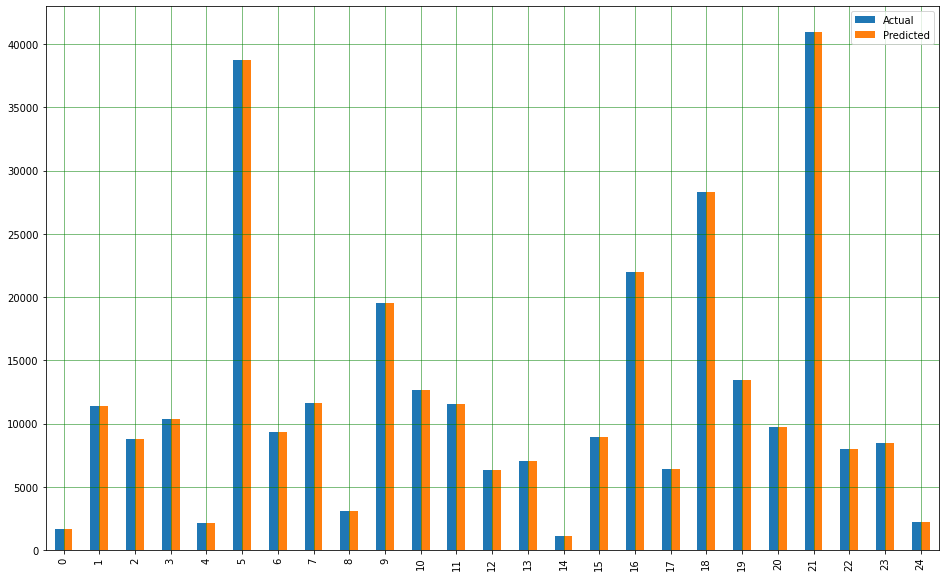

Mean Absolute Error: 6.7083718348120744e-12
Root Mean Squared Error: 7.749708432887624e-12


In [8]:
x = data[['age', 'sex', 'bmi', 'children', 'smoker', 'charges',
          'region_northwest', 'region_southeast', 'region_southwest',
          'region_northeast']].values

y = data['charges'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.2,random_state = 1)
regressor = LinearRegression()
regressor.fit(X_train, y_train) 
y_pred = regressor.predict(X_test)

visualization_result(y_test, y_pred)
visualization_error(y_test, y_pred)

Как можно увидеть по MSE, RMSE и графику модель сильно переобучена. Ясно то, что все поля нам не нужны. 

**Улучшение 1.** 

Попробую стандартизировать поля 'bmi', 'age', 'charges', чтобы уменьшить влияние выбросов.

          Actual    Predicted
0     1646.42970   1646.42970
1    11353.22760  11353.22760
2     8798.59300   8798.59300
3    10381.47870  10381.47870
4     2103.08000   2103.08000
..           ...          ...
263  40103.89000  40103.89000
264  42983.45850  42983.45850
265  44202.65360  44202.65360
266   2136.88225   2136.88225
267   5227.98875   5227.98875

[268 rows x 2 columns]


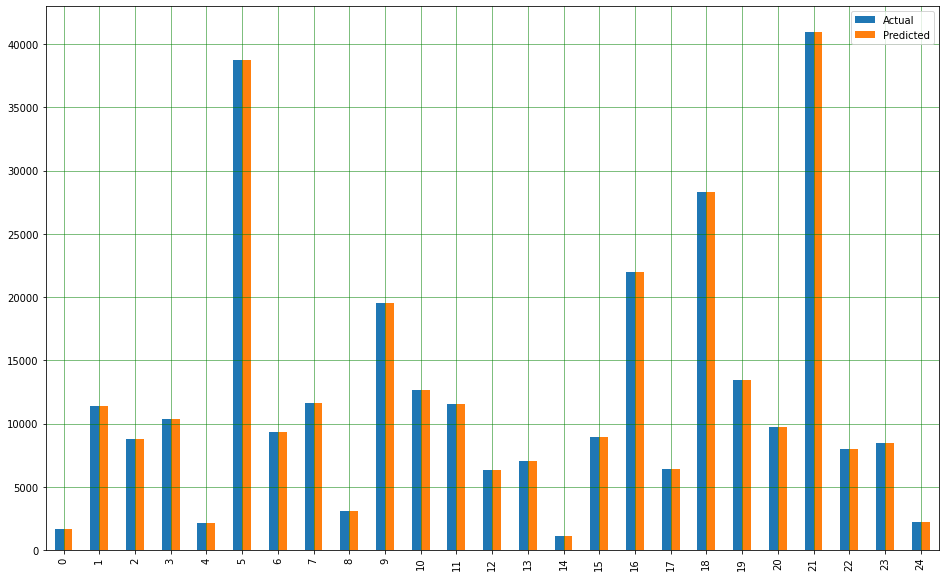

Mean Absolute Error: 5.9151091984709475e-12
Root Mean Squared Error: 6.424135916820687e-12


In [9]:
x = data[['age', 'sex', 'bmi', 'children', 'smoker', 'charges',
          'region_northwest', 'region_southeast', 'region_southwest',
          'region_northeast']].values

y = data['charges'].values.reshape(-1,1)

scaler = StandardScaler()
scaler1 = StandardScaler()
y_train_transform = scaler.fit_transform(y)
x[:, [0]] = scaler1.fit_transform(x[:, [0]])
x[:, [1]] = scaler1.fit_transform(x[:, [1]])

X_train, X_test, y_train, y_test = train_test_split(x,y_train_transform, test_size = 0.2,random_state = 1)

regressor = LinearRegression()
regressor.fit(X_train, y_train) 
y_pred = regressor.predict(X_test)
y_test = scaler.inverse_transform(y_test)
y_pred = scaler.inverse_transform(y_pred)

visualization_result(y_test, y_pred)
visualization_error(y_test, y_pred)

Это не помогло. Стоило попробовать.

**Улучшение 2**

Теперь попробую использовать в X те метки, которые оказались более важными.
В представленном ниже примере использую метки, выделенные классификатор ExtraTreesClassifier и Boruto. Это 'age', 'bmi', 'smoker'.

          Actual     Predicted
0     1646.42970   4219.443648
1    11353.22760  12816.153743
2     8798.59300  12927.892427
3    10381.47870  13509.651992
4     2103.08000   1115.226273
..           ...           ...
263  40103.89000  33865.973695
264  42983.45850  35459.917164
265  44202.65360  37038.463827
266   2136.88225   4537.295426
267   5227.98875   5489.441210

[268 rows x 2 columns]


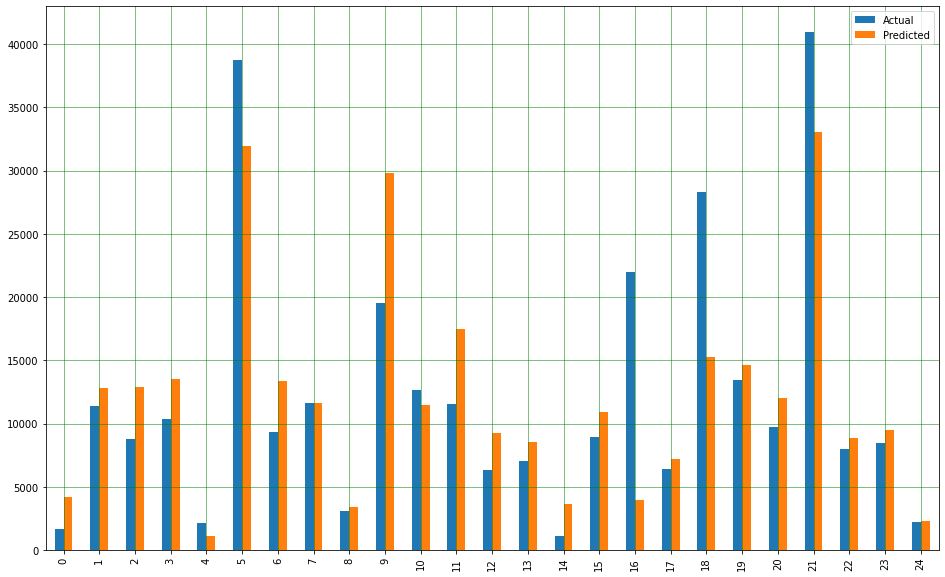

Mean Absolute Error: 4036.503089821638
Root Mean Squared Error: 5970.7635379973135


In [10]:
x = data[['age', 'bmi', 'children', 'smoker']].values

y = data['charges'].values.reshape(-1,1)

scaler = StandardScaler()
scaler1 = StandardScaler()
y_train_transform = scaler.fit_transform(y)
x[:, [0]] = scaler1.fit_transform(x[:, [0]])
x[:, [1]] = scaler1.fit_transform(x[:, [1]])

X_train, X_test, y_train, y_test = train_test_split(x,y_train_transform, test_size = 0.2,random_state = 1)

regressor = LinearRegression()
regressor.fit(X_train, y_train) 
y_pred = regressor.predict(X_test)
y_test = scaler.inverse_transform(y_test)
y_pred = scaler.inverse_transform(y_pred)

visualization_result(y_test, y_pred)
visualization_error(y_test, y_pred)

Из корреляционной матрицы можно выделить 'age', 'bmi', 'smoker'

          Actual     Predicted
0     1646.42970   4646.327066
1    11353.22760  13276.444981
2     8798.59300  13379.081770
3    10381.47870  12748.909250
4     2103.08000   1150.639748
..           ...           ...
263  40103.89000  33479.283979
264  42983.45850  35881.404106
265  44202.65360  36655.257679
266   2136.88225   4963.350855
267   5227.98875   5936.511863

[268 rows x 2 columns]


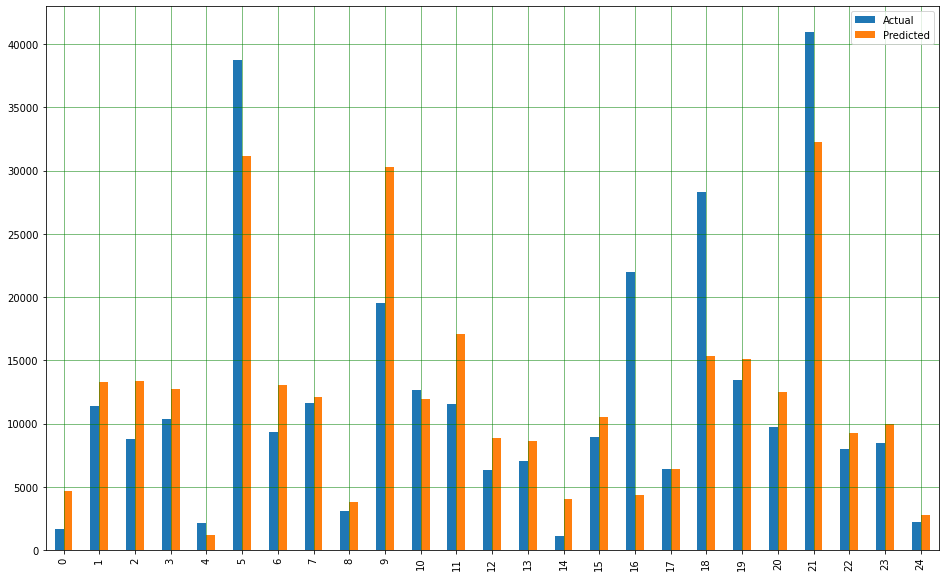

Mean Absolute Error: 4108.165449659962
Root Mean Squared Error: 6025.406712473009


In [11]:
x = data[['age', 'bmi', 'smoker']].values

y = data['charges'].values.reshape(-1,1)

scaler = StandardScaler()
scaler1 = StandardScaler()
y_train_transform = scaler.fit_transform(y)
x[:, [0]] = scaler1.fit_transform(x[:, [0]])
x[:, [1]] = scaler1.fit_transform(x[:, [1]])

X_train, X_test, y_train, y_test = train_test_split(x,y_train_transform, test_size = 0.2,random_state = 1)

regressor = LinearRegression()
regressor.fit(X_train, y_train) 
y_pred = regressor.predict(X_test)
y_test = scaler.inverse_transform(y_test)
y_pred = scaler.inverse_transform(y_pred)

visualization_result(y_test, y_pred)
visualization_error(y_test, y_pred)

**Вывод**

Анализируя полученные данные я могу сделать вывод, что поля 'age', 'bmi', 'smoker' являются наиболее важными по сравнению с остальными.